The pourpose of this notebook is to generate the final graphics for my report, after every calculation was already done and the best model has been found.  

Let's start by loading the necessary libraries and functions, as well as loading the original data and performing the same feature engineering.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
#import my_repository as my

In [2]:
original_data = pd.read_csv('../data/train.csv')
data = original_data.copy()
original_test = pd.read_csv('../data/test.csv')
test = original_test.copy()

In [3]:
dropfeatures = ['Id', 'GarageYrBlt']#, 'YrSold', 'YearBuilt', 'YearRemodAdd'

for neigh in set(data['Neighborhood']):
    value = data[data['Neighborhood'] == neigh]['LotFrontage'].median()
    data.loc[(data['Neighborhood'] == neigh) & (data['LotFrontage'].isnull()), 'LotFrontage'] = value
    value = data[data['Neighborhood'] == neigh]['MasVnrArea'].median()
    data.loc[(data['Neighborhood'] == neigh) & (data['MasVnrArea'].isnull()), 'MasVnrArea'] = value
data['MSSubClass'] = data['MSSubClass'].astype(str)
data = data.fillna('N/A')
dataId = data['Id']
prices = data['SalePrice']
features = data.drop(dropfeatures, axis=1)
features = features.drop('SalePrice', axis=1)
features_before_dummies = features
features = pd.get_dummies(features) #, drop_first=True)

tlist = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea',
         'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'LotFrontage']
for neigh in set(test['Neighborhood']):
    for feature in tlist:
        value = test[test['Neighborhood'] == neigh][feature].median()
        test.loc[(test['Neighborhood'] == neigh) & (test[feature].isnull()), feature] = value
test[tlist] = test[tlist].fillna(test[tlist].mean())
test = test.fillna('N/A')
test_id = test['Id']
test_features = test.drop(dropfeatures, axis=1)
test_features['MSSubClass'] = test_features['MSSubClass'].astype(str)
test_features_before_dummies = test_features
test_features = pd.get_dummies(test_features) #, drop_first=True)

In [4]:
dataNaN = data.isnull().sum()
dataNaN = dataNaN[dataNaN > 0]
testNaN = test.isnull().sum()
testNaN = testNaN[testNaN > 0]

print dataNaN
print testNaN
print features.shape
print test_features.shape

Series([], dtype: int64)
Series([], dtype: int64)
(1460, 317)
(1459, 306)


In [5]:
dropfeat = list(set(features).difference(set(test_features)))
features = features.drop(dropfeat, axis=1)
dropfeat = list(set(test_features).difference(set(features)))
test_features = test_features.drop(dropfeat, axis=1)
print features.shape
print test_features.shape

(1460, 298)
(1459, 298)


In [6]:
logSalePrice = np.log1p(prices)

Now, let's fit the best model I found before to the training data.

In [7]:
gbr_log_model = GradientBoostingRegressor(min_samples_split=7, loss='lad', n_estimators=2935, max_depth=4, random_state=666).fit(features, logSalePrice)

Creating a dataframe containing the predicted and real values for the training data, as well as the pred/real values.

In [8]:
preds = np.exp(gbr_log_model.predict(features)) - 1
real = data['SalePrice']
predreal = pd.DataFrame({'Id': data['Id'], 'real': real, 'pred': preds, 'ratio': preds / real}, columns=['Id', 'pred', 'real', 'ratio'])
predreal.head()

,Id,pred,real,ratio
0,1,208546.964059,208500,1.000225
1,2,181612.103698,181500,1.000618
2,3,216662.949020,223500,0.969409
3,4,140535.625333,140000,1.003826
4,5,276498.615006,250000,1.105994


How many of the data points were predicted with a maximum relative error of 20% (up or down)? 10%? 5%?

In [9]:
ratio = predreal['ratio']
print len(ratio[(ratio >= 0.8) & (ratio <= 1.2)]) / float(len(ratio))
print len(ratio[(ratio >= 0.9) & (ratio <= 1.1)]) / float(len(ratio))
print len(ratio[(ratio >= 0.95) & (ratio <= 1.05)]) / float(len(ratio))

0.983561643836
0.941780821918
0.834931506849


Graphically, how do we compare predicted vs real values?

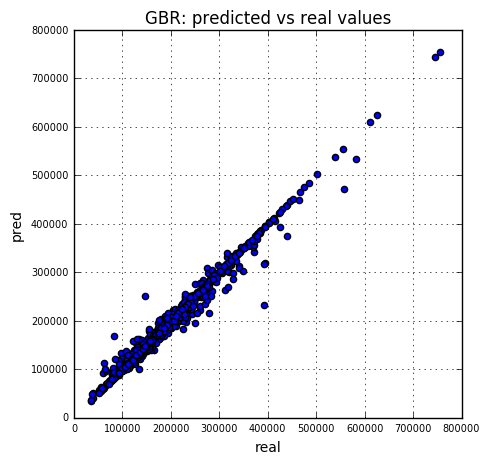

In [10]:
predreal_plot_1 = predreal.plot(x='real', y='pred', kind='scatter', title='GBR: predicted vs real values', xlim=(0, 800000), ylim=(0, 800000), grid=True, figsize=(5, 5), fontsize=7)
fig = predreal_plot_1.get_figure()
fig.savefig('../fig/predreal_plot_1.png')

This is a better way, because for this problem relative error is more important than absolute error.

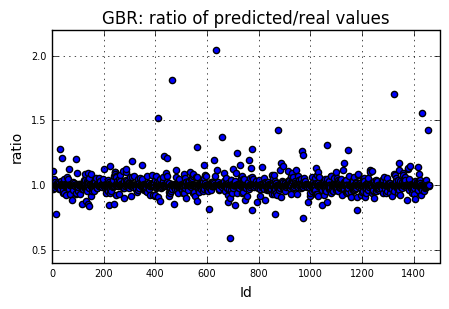

In [11]:
predreal_plot_2 = predreal.plot(x='Id', y='ratio', kind='scatter', title='GBR: ratio of predicted/real values', xlim=(0, 1500), grid=True, figsize=(5, 3), fontsize=7)
fig = predreal_plot_2.get_figure()
fig.savefig('../fig/predreal_plot_2.png')

What are the most important input variables, according to our model?

In [12]:
#gbr_log_model.feature_importances_
list(features.columns)
importances = pd.DataFrame({'feature': features.columns, 'importance': gbr_log_model.feature_importances_})

In [13]:
importances.sort_values(by='importance', ascending=False).head(15)

,feature,importance
14,GrLivArea,0.061795
26,OpenPorchSF,0.057310
10,TotalBsmtSF,0.054382
12,2ndFlrSF,0.049577
6,MasVnrArea,0.049289
11,1stFlrSF,0.048879
27,EnclosedPorch,0.047717
25,WoodDeckSF,0.040899
1,LotArea,0.040034
24,GarageArea,0.036587


In [14]:
importances.sort_values(by='importance', ascending=False).head(15).to_csv('gbr_important_features.csv')

And what about the least important ones?

In [15]:
importances[importances['importance'] <= 0.0001].sort_values(by='feature')

,feature,importance
118,BldgType_Twnhs,0.000032
192,BsmtCond_N/A,0.000000
193,BsmtCond_Po,0.000000
198,BsmtExposure_N/A,0.000028
204,BsmtFinType1_N/A,0.000042
188,BsmtQual_N/A,0.000068
108,Condition1_RRNe,0.000000
110,Condition2_Artery,0.000000
111,Condition2_Feedr,0.000071
113,Condition2_PosA,0.000074


In [16]:
importances[importances['importance'] <= 0.0001].sort_values(by='feature').to_csv('gbr_unimportant_features.csv')